In [62]:
!pip install pandas scikit-learn playsound

In [122]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import os
import pygame  # For playing audio
import librosa
import numpy as np
import soundfile as sf  # To save the filtered audio

# Initialize the pygame mixer
pygame.mixer.init()

# Signal-to-Noise Ratio (SNR) Calculation
def calculate_snr(original, filtered):
    # Ensure both signals have the same length
    min_len = min(len(original), len(filtered))
    original = original[:min_len]
    filtered = filtered[:min_len]
    
    noise = original - filtered
    signal_power = np.sum(original ** 2)
    noise_power = np.sum(noise ** 2)
    snr = 10 * np.log10(signal_power / noise_power)
    return snr

# Root Mean Square Error (RMSE) Calculation
def calculate_rmse(original, filtered):
    # Ensure both signals have the same length
    min_len = min(len(original), len(filtered))
    original = original[:min_len]
    filtered = filtered[:min_len]
    
    rmse = np.sqrt(np.mean((original - filtered) ** 2))
    return rmse

# Spectral Subtraction Noise Reduction Function
def spectral_subtraction(audio, sr, noise_estimation_window=20, threshold=0.1):
    D = librosa.stft(audio)  # Short-Time Fourier Transform (STFT)
    magnitude, phase = librosa.magphase(D)  # Separate magnitude and phase
    noise_profile = np.mean(magnitude[:, :noise_estimation_window], axis=1, keepdims=True)
    magnitude_clean = magnitude - noise_profile
    magnitude_clean = np.maximum(magnitude_clean, threshold)  # Avoid negative values
    D_clean = magnitude_clean * phase  # Combine with phase
    audio_clean = librosa.istft(D_clean)  # Inverse STFT to get the time-domain signal
    return audio_clean

# Load your dataset
df = pd.read_csv("C:\\Users\\Hemanth\\sem3\\moc\\song_describer.csv")  # Your dataset file
df.columns = df.columns.str.strip()

# Step 2: Check if necessary columns exist
if 'caption' not in df.columns or 'track_id' not in df.columns:
    print("Error: Dataset does not contain required columns ('caption' and 'track_id').")
else:
    # Step 3: Vectorize captions
    vectorizer = TfidfVectorizer(stop_words='english')
    X = vectorizer.fit_transform(df['caption'])  # Using 'caption' column

    # Step 4: Get user input and match to the most relevant caption
    user_input = input("Enter your prompt: ")
    user_vector = vectorizer.transform([user_input])
    similarity = cosine_similarity(user_vector, X)

    # Step 5: Find the index of the most similar caption
    best_match_index = similarity.argmax()

    # Step 6: Get the track_id corresponding to the matched caption
    track_id = df.iloc[best_match_index]['track_id']

    # Step 7: Format track_id to match the folder structure (e.g., '01', '02', ...)
    track_id_str = str(track_id)

    # Step 8: Find the corresponding audio file
    found_audio = False
    for folder_num in range(100):  # Iterate over folders '00' to '99'
        folder_name = str(folder_num).zfill(2)
        audio_folder_path = os.path.join("C:\\Users\\Hemanth\\sem3\\moc\\audio\\audio", folder_name)

        if os.path.exists(audio_folder_path):
            for file in os.listdir(audio_folder_path):
                if file.startswith(track_id_str):
                    audio_file_path = os.path.join(audio_folder_path, file)

                    if os.path.isfile(audio_file_path):
                        print(f"Playing audio: {audio_file_path}")

                        # Load and play the original audio file
                        original_audio, sr = librosa.load(audio_file_path, sr=None)
                        pygame.mixer.music.load(audio_file_path)
                        pygame.mixer.music.play()

                        while pygame.mixer.music.get_busy():
                            continue

                        # Apply spectral subtraction for noise reduction
                        filtered_audio = spectral_subtraction(original_audio, sr)

                        # Ensure both the original and filtered audio have the same length
                        min_len = min(len(original_audio), len(filtered_audio))
                        original_audio = original_audio[:min_len]
                        filtered_audio = filtered_audio[:min_len]

                        # Save the filtered audio to a file
                        filtered_audio_path = "filtered_audio.wav"
                        try:
                            sf.write(filtered_audio_path, filtered_audio, sr)
                            print(f"Filtered audio saved to {filtered_audio_path}")
                        except Exception as e:
                            print(f"Error while saving the filtered audio: {e}")

                        # Calculate SNR and RMSE
                        snr = calculate_snr(original_audio, filtered_audio)
                        rmse = calculate_rmse(original_audio, filtered_audio)

                        print(f"Signal-to-Noise Ratio (SNR): {snr:.2f} dB")
                        print(f"Root Mean Square Error (RMSE): {rmse:.4f}")

                        found_audio = True
                        break
            if found_audio:
                break

    if not found_audio:
        print(f"Audio file for track_id {track_id} not found in any folder.")

Enter your prompt:  pop


Playing audio: C:\Users\Hemanth\sem3\moc\audio\audio\50\35350.2min.mp3
Filtered audio saved to filtered_audio.wav
Signal-to-Noise Ratio (SNR): 23.76 dB
Root Mean Square Error (RMSE): 0.0178


Training set score: 0.893
Test set score: 0.733


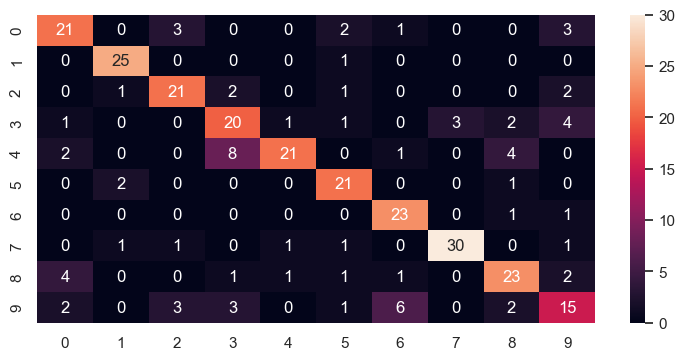

              precision    recall  f1-score   support

           0       0.70      0.70      0.70        30
           1       0.86      0.96      0.91        26
           2       0.75      0.78      0.76        27
           3       0.59      0.62      0.61        32
           4       0.88      0.58      0.70        36
           5       0.72      0.88      0.79        24
           6       0.72      0.92      0.81        25
           7       0.91      0.86      0.88        35
           8       0.70      0.70      0.70        33
           9       0.54      0.47      0.50        32

    accuracy                           0.73       300
   macro avg       0.74      0.75      0.74       300
weighted avg       0.74      0.73      0.73       300

The predicted genre is: classical


In [123]:
import pandas as pd
import numpy as np
import librosa
import librosa.display
import pickle
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Load the dataset and pre-process it (for training phase)
df = pd.read_csv("C:\\Users\\Hemanth\\sem3\\moc\\features_30_sec.csv")
class_encod = df.iloc[:, -1]  # Get the genre labels
converter = LabelEncoder()  # Initialize label encoder for converting genre names to integers
y = converter.fit_transform(class_encod)  # Transform genres to integers
df = df.drop(labels="filename", axis=1)  # Drop 'filename' column as it's not needed for training

# Scale the features (standardize)
scaler = StandardScaler()
X = scaler.fit_transform(np.array(df.iloc[:, :-1], dtype=float))  # Standardize features

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

# Initialize and train the SVM classifier
svclassifier = SVC(kernel='rbf')
svclassifier.fit(X_train, y_train)

# Evaluate the model
print("Training set score: {:.3f}".format(svclassifier.score(X_train, y_train)))
print("Test set score: {:.3f}".format(svclassifier.score(X_test, y_test)))

# Predict on the test set
y_pred = svclassifier.predict(X_test)

# Confusion matrix and classification report
cf_matrix = confusion_matrix(y_test, y_pred)
sns.set(rc={'figure.figsize':(9, 4)})
sns.heatmap(cf_matrix, annot=True)
plt.show()

print(classification_report(y_test, y_pred))

# Save the trained model and the scaler for later use
with open('svm_model.pkl', 'wb') as f:
    pickle.dump(svclassifier, f)

with open('scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

with open('label_encoder.pkl', 'wb') as f:
    pickle.dump(converter, f)


# Function to extract features from a new audio file
def extract_features(file_path):
    y, sr = librosa.load(file_path, sr=None)  # Load the audio file
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=39)  # Extract MFCC features
    chroma = librosa.feature.chroma_stft(y=y, sr=sr)  # Extract chroma features
    contrast = librosa.feature.spectral_contrast(y=y, sr=sr)  # Extract spectral contrast features
    
    # Combine all the features into a single feature vector (mean of each feature type)
    features = np.hstack((np.mean(mfcc, axis=1),
                          np.mean(chroma, axis=1),
                          np.mean(contrast, axis=1)))
    return features


# Function to predict the genre of a new audio file
def predict_genre(file_path):
    # Load the trained model, scaler, and label encoder
    with open('svm_model.pkl', 'rb') as f:
        svclassifier = pickle.load(f)

    with open('scaler.pkl', 'rb') as f:
        scaler = pickle.load(f)

    with open('label_encoder.pkl', 'rb') as f:
        converter = pickle.load(f)

    # Extract features from the audio file
    features = extract_features(file_path)

    # Scale the features using the saved scaler
    scaled_features = scaler.transform([features])

    # Predict the genre using the trained SVM model
    prediction = svclassifier.predict(scaled_features)

    # Convert the numeric prediction back to the genre label
    predicted_genre = converter.inverse_transform(prediction)
    
    return predicted_genre[0]


# Example usage: Predict genre for a new audio file
file_path = "filtered_audio.wav"  # Replace with the path to your test file
predicted_genre = predict_genre(file_path)
print(f"The predicted genre is: {predicted_genre}")
